In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBBSSB'
m='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

/Users/toby/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.0 	required version>=0.19.2 ******* Update Version ******
     numpy as    np 	version=1.11.2 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18 	required version>=0.18.1 ******* Update Version ******
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py']) #'lib/spark_PCA.py'

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
data_dir='../../Data/Weather'
file_index='SSSBBSSB'

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1677.9| 37.5167|-114.2667|       PRCP|USC00260645|    16|[00 00 C0 4D 00 0...|1950.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       PRCP|USC00421272|    31|[C0 50 80 4A 00 0...|1906.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       PRCP|USC00421272|     2|[20 51 00 00 00 0...|1907.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       PRCP|USC00421272|    32|[00 00 00 00 00 0...|1908.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       PRCP|USC00421272|    27|[00 00 00 00 00 0...|1912.0|SSSBBSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [8]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(2441, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

In [9]:
T[16:18].shape

(2, 365)

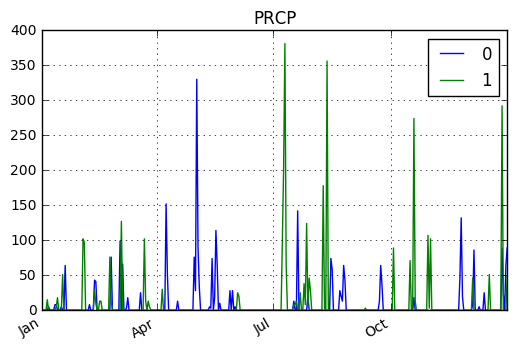

In [10]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

In [11]:
STAT[m]['eigvec'][:,:3]

array([[-0.03446343, -0.03558685,  0.03464178],
       [-0.03636891,  0.01007843,  0.03822262],
       [-0.02981609, -0.0046733 ,  0.01898595],
       ..., 
       [-0.03829045, -0.12436235,  0.2309825 ],
       [-0.04401332, -0.09323507,  0.08094571],
       [-0.0105964 , -0.01946731,  0.00584479]])

In [12]:
STAT[m]['eigval'][:3]

array([ 13461.98738315,  10066.67401895,   8207.7956105 ])

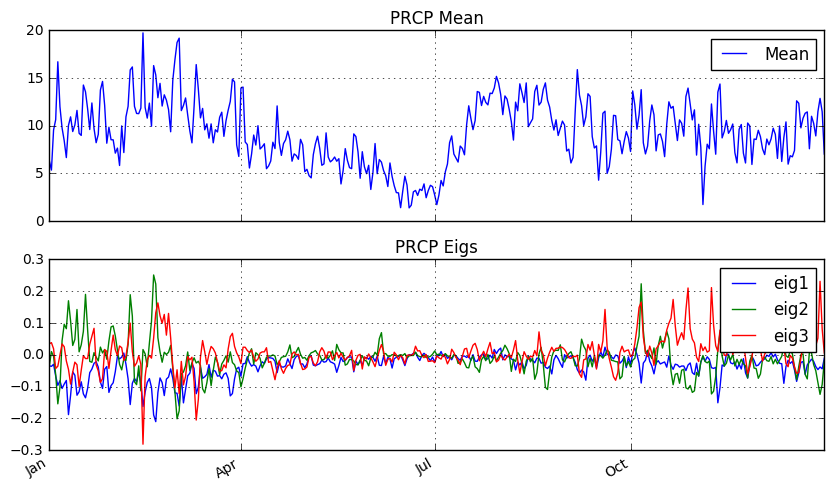

In [13]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
#k=50
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

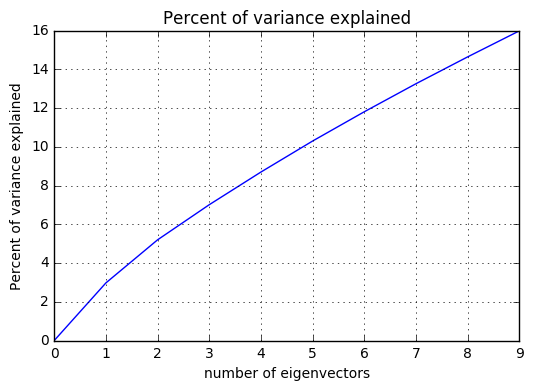

In [14]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; 
eigvals/=sum(eigvals); 
cumvar=cumsum(eigvals); 
cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [16]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.925608789509
residual normalized norm  after mean + top eigs: [ 0.99975595  0.99919529  0.99428913]


In [17]:
total_var

('total_energy', 690044.88360595703)

In [18]:
reductions

('reduction in var for mean,eig1,eig2,...',
 array([  7.43912105e-02,   4.60765672e+00,   1.05852239e+01,
          9.26284397e+01]))

In [19]:
residuals

('residual var after mean, eig1,eig2,...',
 array([ 0.92560879,  0.99975595,  0.99919529,  0.99428913]))

In [20]:
print eigen_decomp.n

3


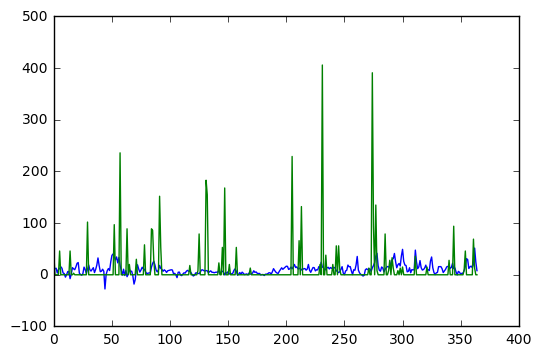

In [21]:
A = eigen_decomp.mean
#plot(A,label='mean')
for n in xrange(eigen_decomp.n):
    g=eigen_decomp.v[i] * eigen_decomp.C[i]#  eigen_decomp.coeff['c'+str(i)]
    A=A+g

plot(A)
#plot(eigen_decomp.f, label='target')
plt.plot(eigen_decomp.f, label='target')
plt.show()

In [22]:
recon_plot??

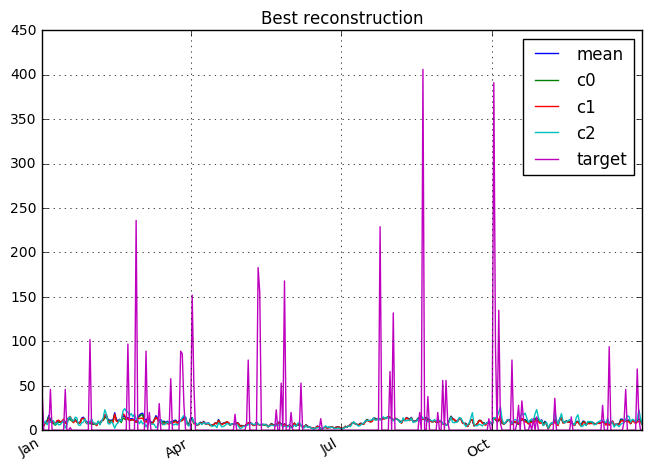

In [23]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [24]:
df.count()

2441

In [26]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [27]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row) #,Mean,v)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

res_mean : 1.10319652693 res_1 : 0.910075833509 res_2 : 0.892488870059 res_3 : 0.877208183599
res_mean : 0.936473378008 res_1 : 0.999945156637 res_2 : 0.994727064295 res_3 : 0.993877925003
res_mean : 0.925608705106 res_1 : 0.999755954251 res_2 : 0.999195315296 res_3 : 0.994289048776


In [28]:
Mean

array([  6.33446232,   5.35002103,   9.54660481,  10.63552189,
        16.6986532 ,  11.98016878,   9.75769069,   8.42641509,
         6.66246851,  10.03826745,  10.92824171,   9.38965952,
        10.07650273,  11.60394792,   9.20603015,   8.98532495,
        14.26152557,  13.55048178,  11.76194468,   9.60193766,
        12.38315789,   9.70415443,   8.22045264,   9.09319899,
        13.73967987,  14.63908822,  12.12747995,   8.16638726,
         9.8431455 ,   8.53319328,   8.52155537,   7.12838683,
         7.65461347,   5.83381924,   9.97960033,   7.18723937,
        10.9308045 ,  12.03290296,  15.84416667,  16.15721435,
        12.03256785,  11.28428512,  11.26416667,  11.83741186,
        19.72326259,  11.92493745,  10.79774812,  12.36973739,
         9.94129892,  16.29765886,  15.32051818,  12.93099122,
        14.43708333,  12.06169237,  13.23706177,  12.67778241,
        11.69557965,   9.36595567,  14.76271893,  16.90666667,
        18.71953255,  19.17389491,  11.58229426,  12.12

In [29]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 2441
after filter 2147


In [30]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [31]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [32]:
df3=df3.sort(df3.res_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+-------------------+-------------------+
|          res_mean|             res_1|              res_2|              res_3|
+------------------+------------------+-------------------+-------------------+
|0.9085690191159226|0.7049720017322493|0.43419714955311367|0.41834828691440495|
|0.8906956235992943|0.7691609802569201|0.47789553233038917| 0.4448636976511246|
|0.9176498438640295|0.7606175137621703| 0.4798327316432624| 0.4486296399954135|
|0.8969766302349239|0.7997627766921555| 0.5172722826512869|0.45308808667208533|
+------------------+------------------+-------------------+-------------------+
only showing top 4 rows



/Users/toby/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


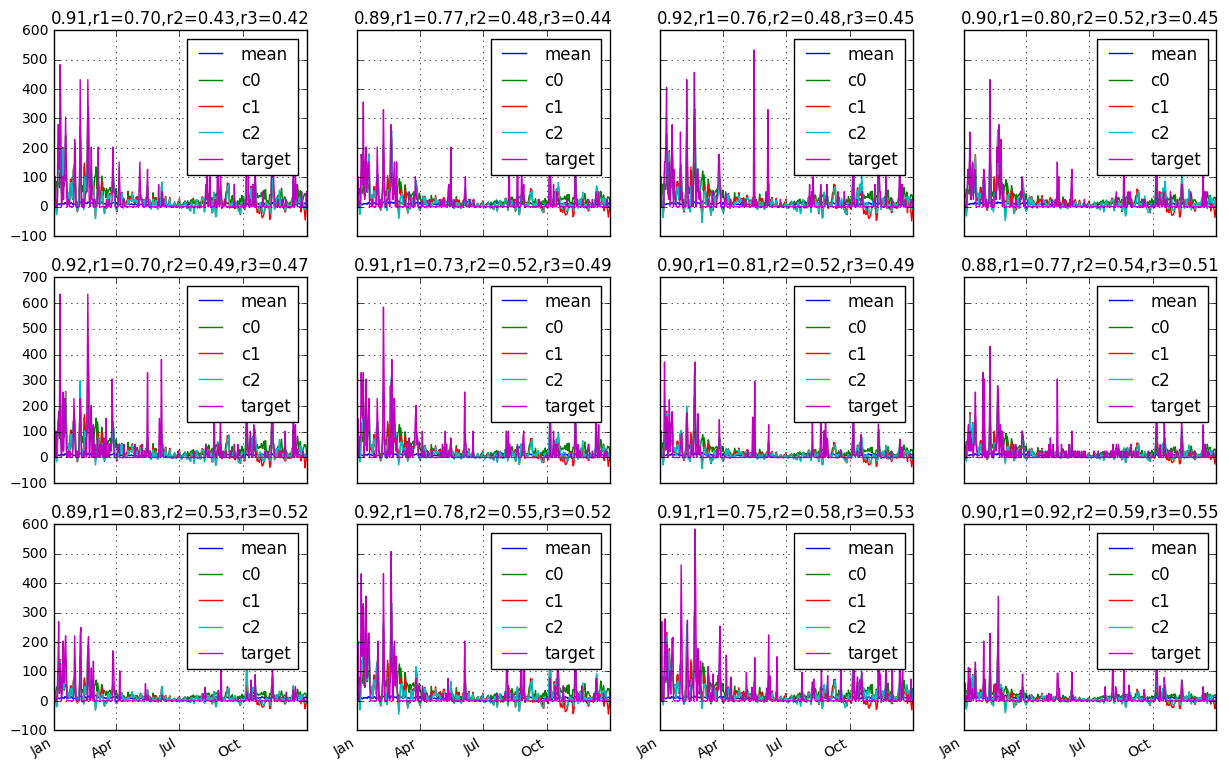

In [33]:
plot_recon_grid(rows)

In [34]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
|0.9049224606354178|0.9999518216757639|0.9999201572036088|0.9997075482614458|
|0.9337444295445472|0.9998793271398233|0.9997618569909467|0.9995163386795161|
|0.9213624094161509|0.9999839346362088|0.9997806134883248|  0.99948665769826|
|0.9349858530880116|0.9994951200803011| 0.999472222396236|0.9994331529562233|
+------------------+------------------+------------------+------------------+
only showing top 4 rows



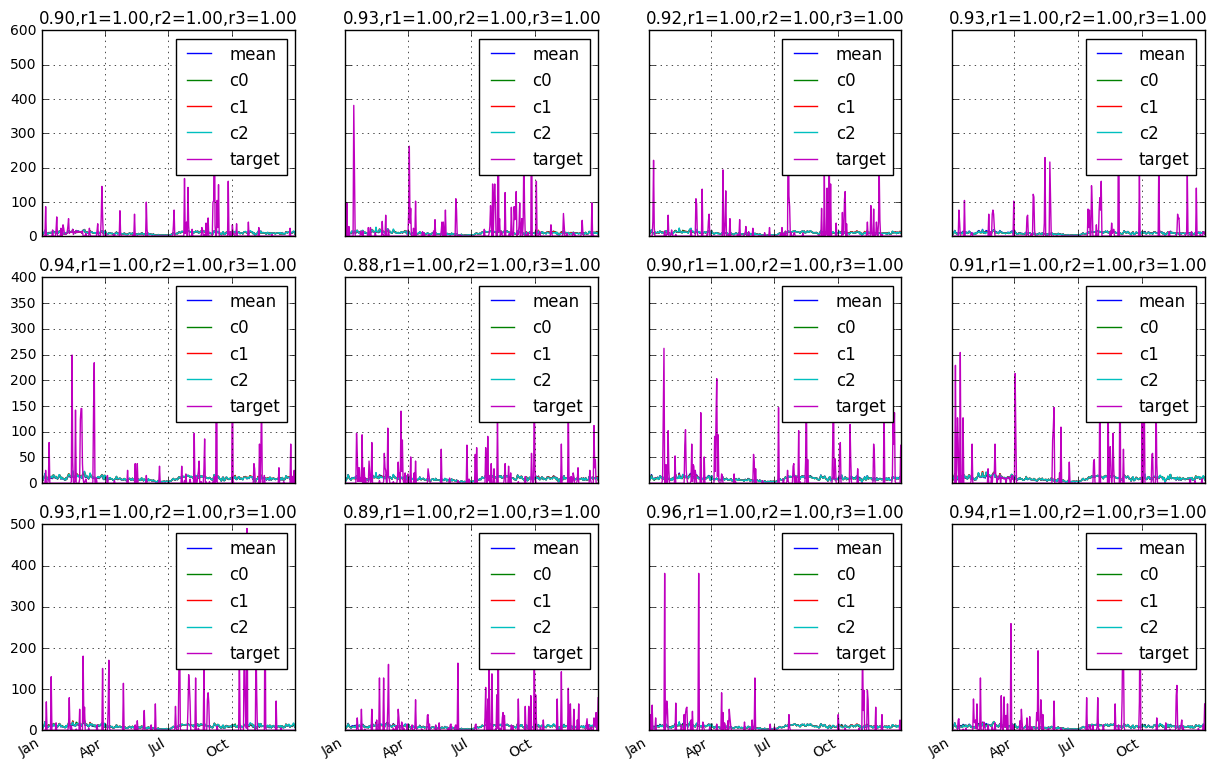

In [35]:
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

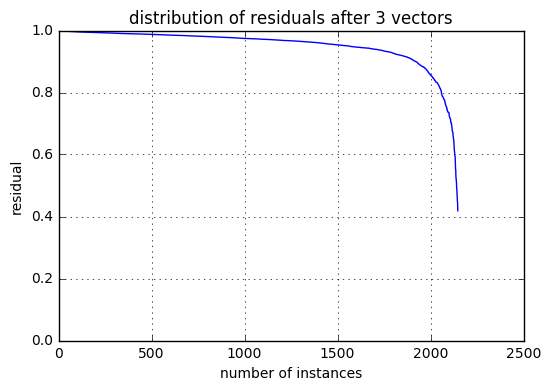

In [36]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [37]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [38]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.0M	../../Data/Weather/US_Weather_SSSBBSSB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SSSBBSSB_PRCP.parquet
2.3M	../../Data/Weather/decon_SSSBBSSB_SNWD.parquet
